# Datasets Desbalanceados

## 1. Datasets Sintéticos

Vamos a comenzar generando un dataset sintético. La ventaja de este enfoque es que podemos controlar muchas características de este dataset. Por ejemplo, la cantidad de features, si hay features correlacionados o no, la separación entre clases, el desbalanceo, etc.

Vamos a comenzar generando un dataset, que luego separaremos en un dataset medido y en un dataset no medido. De esta forma, simulamos (de una manera muy inocente) el proceso de medición. Esto se podría hacer mejor: en este proceso de medición podríamos agregar ruido, valores mal medidos, etiquetas intercambiadas, etc.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

import pandas as pd
import seaborn as sns
sns.set()

from sklearn.datasets import make_classification

La siguiente celda genera los datos con los que vamos a trabajar. 

In [67]:
X_real, y_real = make_classification(n_samples=100000,n_features=4, n_informative=4,
                                     n_redundant=0, n_clusters_per_class=1,
                                     class_sep=1.0, weights = [0.99], random_state=40)

Y miramos la cantidad de instancias con etiqueta positiva y qué porcentaje del dataset representa.

In [68]:
print(y_real.sum())
print(y_real.sum()/y_real.size)

1470
0.0147


Pasamos a un DataFrame de Pandas para poder aprovechar algunas funcionalidades de la librería.

In [69]:
df_real = pd.DataFrame()

In [70]:
X_real

array([[ 3.97682085,  0.37296147, -0.65073907,  2.07328398],
       [ 1.62908469, -1.05959721, -1.6540426 ,  0.43143026],
       [ 1.17856263, -0.25037619,  2.3292688 ,  1.37056396],
       ...,
       [ 0.18198287, -1.4505103 , -2.7849971 , -0.11736562],
       [ 1.42696897, -1.95836633,  1.10633755,  1.04821574],
       [ 2.56375938, -2.07377389,  0.02036046,  1.38985972]])

In [71]:
X_real.shape[1]



4

In [72]:
for i in range(X_real.shape[1]):
    df_real['x' + str(i)] = X_real[:,i]
df_real['y'] = y_real  

Como ya viene mezclado al azar, seleccionar las diez mil primeras instancias es equivalente a muestrear al azar el dataset original.

In [73]:
N = 10000
df_medido = df_real[:N]
df_medido.head()

x0        x1        x2        x3  y
0  3.976821  0.372961 -0.650739  2.073284  0
1  1.629085 -1.059597 -1.654043  0.431430  0
2  1.178563 -0.250376  2.329269  1.370564  0
3  1.093868 -1.616160  1.727165  1.464183  0
4 -0.652038 -2.527268  1.589253  1.248053  0

Y dejamos el resto de los los datos como instancias 'no medidas'.

In [74]:
df_no_medido = df_real[N:].reset_index(drop = True)
df_no_medido.head()

x0        x1        x2        x3  y
0  0.482545 -0.448791 -0.812647  0.595696  0
1  5.544468 -1.917801  0.870708  3.020132  0
2  2.154670 -1.124450  0.215696  1.889750  0
3  2.290953 -0.976496  0.518059  1.531779  0
4  3.191610 -0.883649  1.206954  2.068909  0

In [75]:
print(df_real.shape)
print(df_medido.shape)
print(df_no_medido.shape)

(100000, 5)
(10000, 5)
(90000, 5)


¿Cuántas instancias positivas y qué porcentaje hay en cada dataset?

In [76]:
print(df_medido.y.sum())
print(df_medido.y.sum()/df_medido.size)

print(df_no_medido.y.sum())
print(df_no_medido.y.sum()/df_no_medido.size)

162
0.00324
1308
0.0029066666666666668


### Exploración de los datos

Miremos cómo es el dataset con el que vamos a trabajar, `df_medido`.

In [77]:
df_medido.columns

Index(['x0', 'x1', 'x2', 'x3', 'y'], dtype='object')

In [78]:
df_medido.y.value_counts(dropna=False)

0    9838
1     162
Name: y, dtype: int64

In [79]:
df_medido.columns[:-1]

Index(['x0', 'x1', 'x2', 'x3'], dtype='object')

C:\Users\walgom\Anaconda37\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\walgom\Anaconda37\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


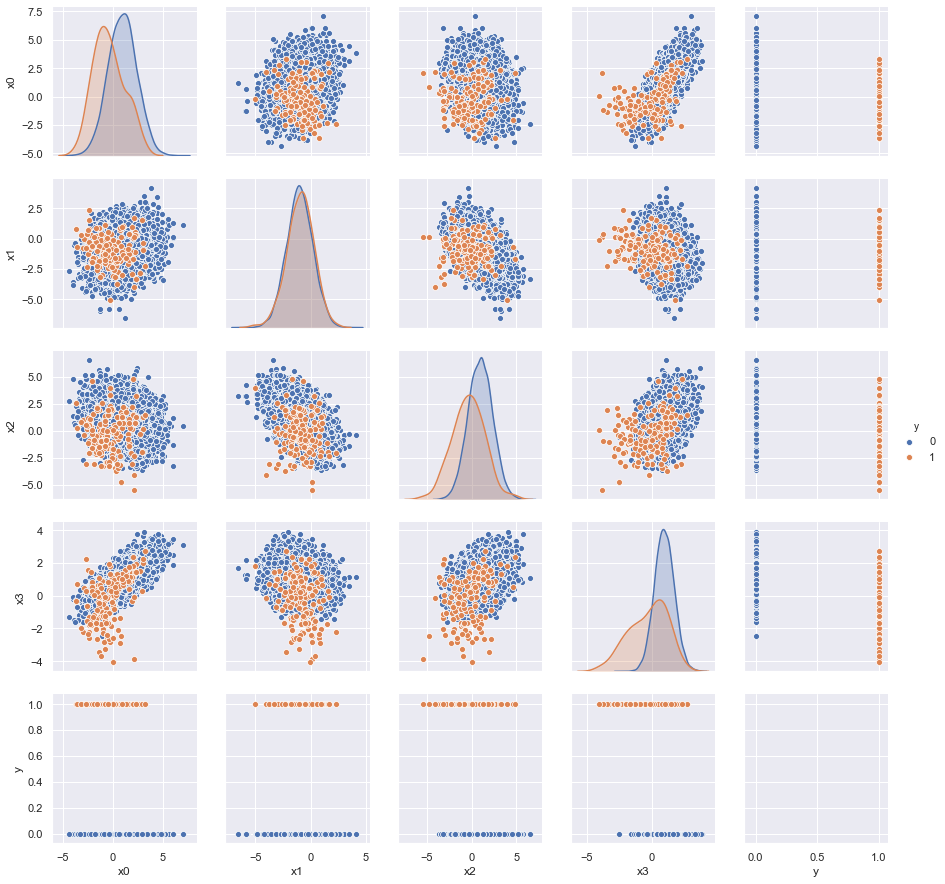

In [80]:
sns.pairplot(data = df_medido, vars = df_medido.columns[:], hue = 'y')

Y cómo queda la tabla de correlaciones.

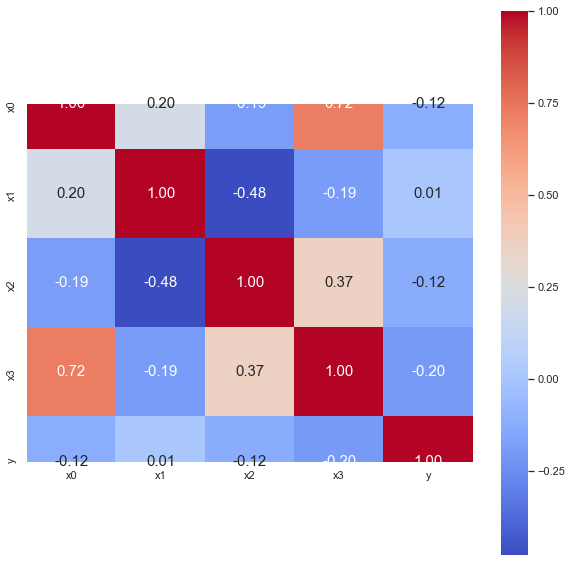

In [81]:
corr = df_medido.corr('pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_medido.columns, 
           yticklabels= df_medido.columns,
           cmap= 'coolwarm')
# plt.xticks(rotation = 45)
# plt.yticks(rotation = 45)
plt.show()

¿Cuáles atributos serán buenos predictores?

**Ejercicio:** Familiarizarse con la función que genera los datos. Cambiar algunos de sus parámetros y volver a correr. 

**Para pensar**: ¿Qué pasa con la tabla de correlaciones a medida que la prevalencia de la clase positiva disminuye?

## 2. Entrenamiento Modelo Uno

Vamos a entrenar un primer modelo de árbol de decisión y evaluarlo usando exactitud. Para ello:

Seleccionamos variables predictoras y etiquetas

In [82]:
X = df_medido.drop('y', axis = 1).values
y = df_medido.y.values

Hacemos un `train_test_split`

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)

Observamos cómo son las distribuciones de las variables predictoras

In [84]:
X_train.shape[1]

4

In [85]:
X_train

array([[ 0.86859054,  1.76699986, -0.61468204,  0.21053376],
       [-0.47039046, -2.82858412,  0.12552653,  0.69059668],
       [-1.36880892, -1.77473041,  0.80789584, -0.22583558],
       ...,
       [ 3.27503806, -1.38506663,  1.96218473,  2.06407532],
       [-0.96806085,  0.07254974,  1.31497389, -0.42065264],
       [ 4.00680951, -0.53153976,  0.66595757,  2.45392038]])

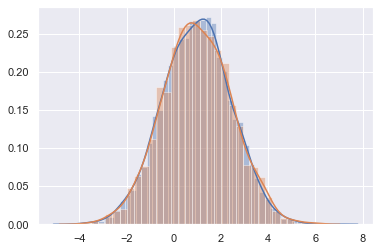

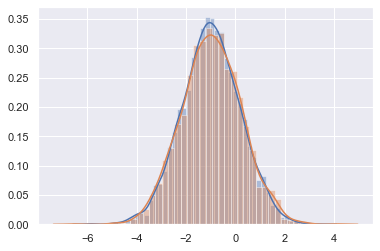

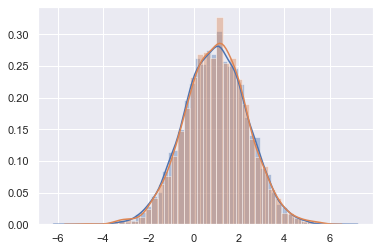

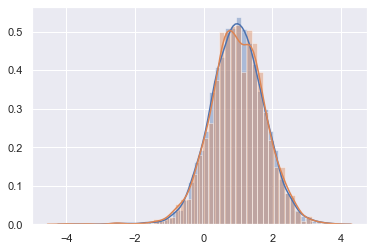

In [86]:
for i in range(X_train.shape[1]):
    sns.distplot(X_train[:,i])
    sns.distplot(X_test[:,i])
    plt.show()

Y la proporción de etiquetas positivas en los datos de train y test.

In [87]:
print('Proporcion de etiquetas positiva en los datos de Train: ', y_train.sum()/y_train.size)
print('Proporcion de etiquetas positiva en los datos de Test: ', y_test.sum()/y_test.size)

Proporcion de etiquetas positiva en los datos de Train:  0.01625
Proporcion de etiquetas positiva en los datos de Test:  0.016


In [88]:
#curva roc
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [89]:
y.shape

(10000,)

In [90]:
# Calcular la curva ROC y el área para cada clase.
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = roc_curve(y_test[:], y_score[:])
roc_auc[0] = auc(fpr[0], tpr[0])

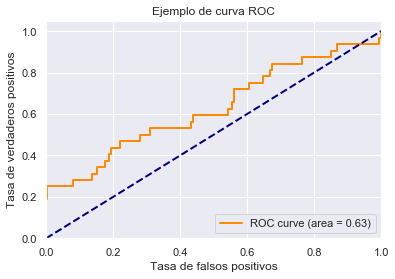

In [91]:
#grafica
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Ejemplo de curva ROC')
plt.legend(loc="lower right")
plt.show()

C:\Users\walgom\Anaconda37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


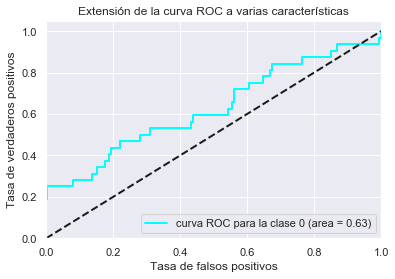

In [92]:
# Agregando las tasas de falsos positivos
all_fpr = np.unique(np.concatenate([fpr[0]]))

# Interpolar todas las curvas ROC 
mean_tpr = np.zeros_like(all_fpr)
for i in range(1):
    mean_tpr += interp(all_fpr, fpr[0], tpr[0])

# Promediando y calculando las AUC
mean_tpr /= 1

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficar todas las curvas
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(1), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='curva ROC para la clase {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Extensión de la curva ROC a varias características')
plt.legend(loc="lower right")
plt.show()

### Entrenamiento del modelo

Vamos a hacer una curva de validación para elegir la mejor profundidad para el árbol de decisión. 

In [93]:
from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

In [94]:
from sklearn.model_selection import cross_validate

tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,50,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad, random_state=42)
    tree_scores = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

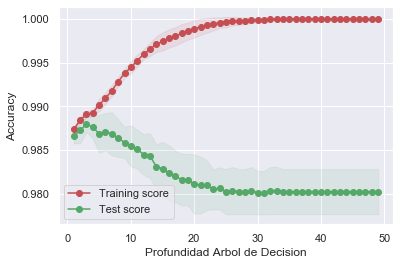

In [95]:
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")


plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

¿Cuál profundidad usarían? ¿Cuál es el *benchmark* de este problema?

Entrenemos un árbol de profundidad tres y evaluémoslo en el conjunto de test.

In [96]:
clf_1 = DecisionTreeClassifier(max_depth = 3, random_state = 42)
clf_1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [97]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = clf_1.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = clf_1.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.989125
Accuracy sobre conjunto de Test: 0.9855


¿Es un buen modelo? Veamos la matriz de confusión en cada conjunto.

In [98]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)


array([[7869,    1],
       [  86,   44]], dtype=int64)

In [99]:
confusion_matrix(y_test, y_test_pred)


array([[1964,    4],
       [  25,    7]], dtype=int64)

¿Cuáles son sus aciertos, Falsos Positivos y Falsos Negativos?¿Es lo mismo si nos interesa la clase 0 que la clase 1? En el caso de un examen médico, ¿un FP tiene el mismo costo que un FN?

**Ejercicio:** calcular la precisión, exhaustividad (recall) y F-Score de este modelo para cada clase sobre el conjunto de Test. Pueden hacerlo a partir de la matriz de confusión o usando funciones que ya están incorporadas en Scikit-Learn.

### ¿Y si lo ponemos "en producción"?

Una de las ventajas de trabajar con datos sintéticos es que podemos ver cómo desempeñaría nuestro modelo si lo ponemos en producción.

In [100]:
X_no_medido = df_no_medido.drop('y', axis = 1).values
y_no_medido = df_no_medido.y.values

In [101]:
# Predecimos sobre todas las instancias que no vio
y_no_medido_pred = clf_1.predict(X_no_medido)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_no_medido_pred,y_no_medido))

Accuracy sobre conjunto de Train: 0.9880777777777778


In [102]:
confusion_matrix(y_no_medido, y_no_medido_pred)

array([[88558,   134],
       [  939,   369]], dtype=int64)

**Ejercicio:** medir precisión, exhaustividad y F-Score

**Ejercicio:** repetir para un modelo de vecinos más cercanos.

## 3. Balanceando el Dataset

Vamos a balancear el dataset subsampleando la clase más prevalente. Luego, volvemos a analizar los datos y entrenar los modelos.

In [103]:
mask = df_medido.y == 1

df_subsample = pd.concat([df_medido[mask], df_medido[~mask].sample(n = mask.sum())])

In [104]:
df_subsample = df_subsample.sample(frac=1,  random_state=42).reset_index(drop=True)

In [105]:
df_subsample.y.size

324

In [106]:
df_subsample.columns[:-1]

Index(['x0', 'x1', 'x2', 'x3'], dtype='object')

In [107]:
df_subsample.columns[:]

Index(['x0', 'x1', 'x2', 'x3', 'y'], dtype='object')

Hacemos el `pairplot`

C:\Users\walgom\Anaconda37\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\walgom\Anaconda37\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


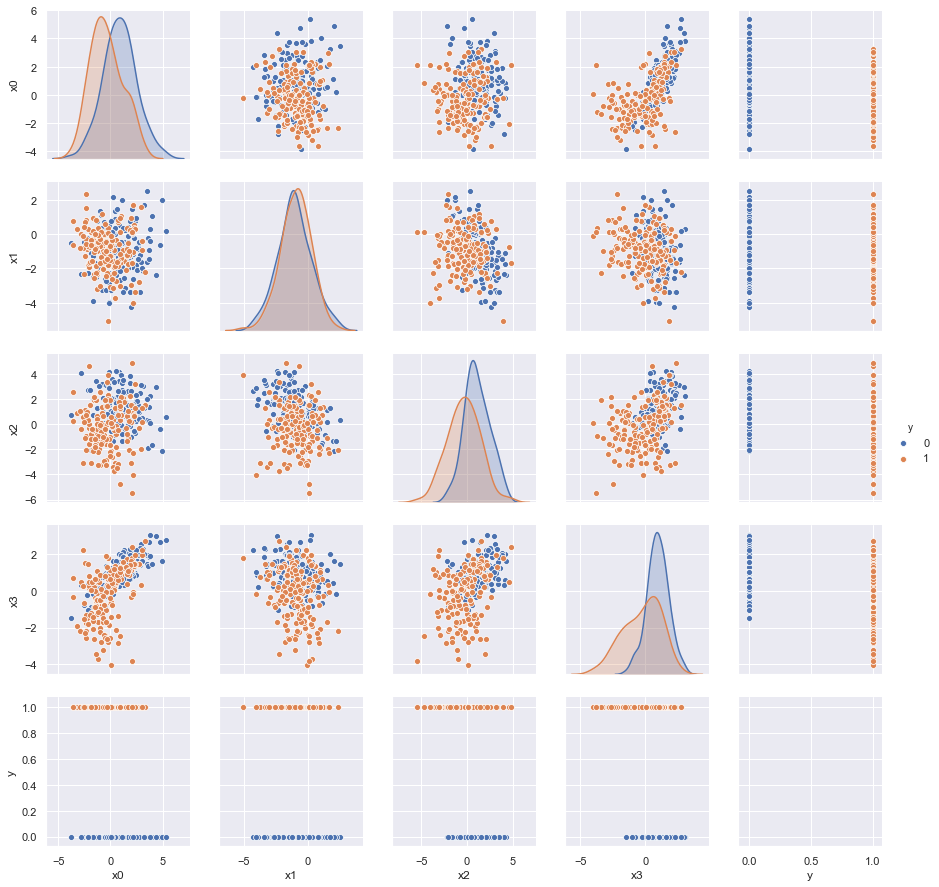

In [108]:
sns.pairplot(data = df_subsample, vars = df_subsample.columns[:], hue = 'y')

Y la tabla de correlaciones.

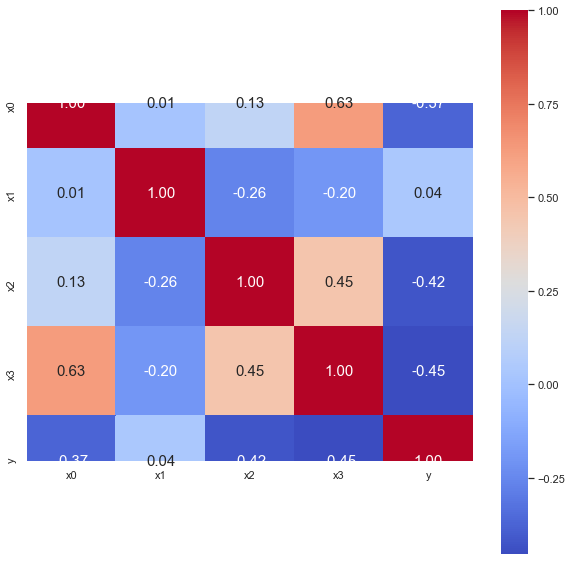

In [109]:
corr = df_subsample.corr('pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_subsample.columns, 
           yticklabels= df_subsample.columns,
           cmap= 'coolwarm')
# plt.xticks(rotation = 45)
# plt.yticks(rotation = 45)
plt.show()

¿Notan algo diferente en la tabla con respecto a la anterior? Si quieren, copien la celda de código de la tabla anterior para poder verlas juntas.

## 4. Entrenamiento Modelo Dos

Seleccionamos variables predictoras y etiquetas

In [110]:
X = df_subsample.drop('y', axis = 1).values
y = df_subsample.y.values

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify = y)

Observamos cómo son las distribuciones de las variables predictoras

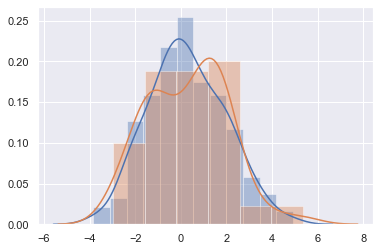

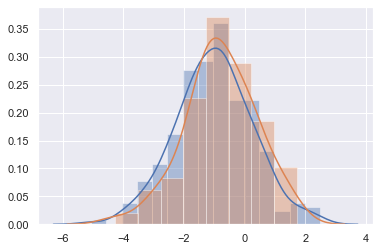

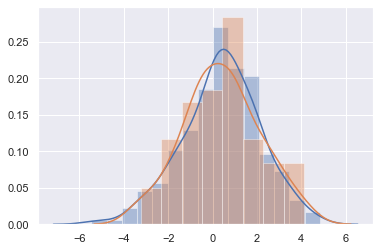

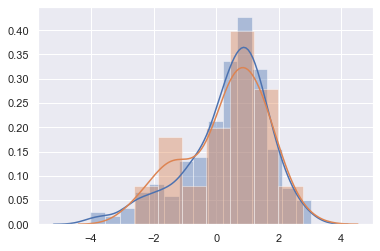

In [112]:
for i in range(X_train.shape[1]):
    sns.distplot(X_train[:,i])
    sns.distplot(X_test[:,i])
    plt.show()

Y la proporción de etiquetas positivas en los datos de train y test.

In [113]:
print('Proporcion de etiquetas positiva en los datos de Train: ', y_train.sum()/y_train.size)
print('Proporcion de etiquetas positiva en los datos de Test: ', y_test.sum()/y_test.size)

Proporcion de etiquetas positiva en los datos de Train:  0.4980694980694981
Proporcion de etiquetas positiva en los datos de Test:  0.5076923076923077


### Entrenamiento del modelo

Volvemos a hacer la curva de validación.

In [114]:
tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,50,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad, random_state=42)
    tree_scores = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

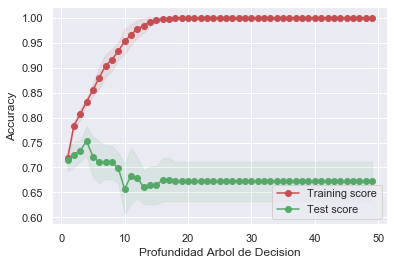

In [115]:
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")


plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

¿Cuál profunidad usarían? Cuál es el *benchmark* de este problema?

Entrenemos un árbol de profundidad tres y evaluémoslo en el conjunto de test.

In [116]:
clf_2 = DecisionTreeClassifier(max_depth = 3, random_state = 42)
clf_2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [117]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = clf_2.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = clf_2.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.806949806949807
Accuracy sobre conjunto de Test: 0.6615384615384615


¿Es un buen modelo? Veamos la matriz de confusión en cada conjunto.

In [118]:
confusion_matrix(y_train, y_train_pred)

array([[117,  13],
       [ 37,  92]], dtype=int64)

In [119]:
confusion_matrix(y_test, y_test_pred)

array([[21, 11],
       [11, 22]], dtype=int64)

In [120]:
#curva roc
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [121]:
# Calcular la curva ROC y el área para cada clase.
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = roc_curve(y_test[:], y_score[:])
roc_auc[0] = auc(fpr[0], tpr[0])

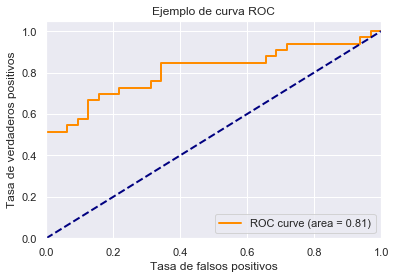

In [122]:
#grafica
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Ejemplo de curva ROC')
plt.legend(loc="lower right")
plt.show()

C:\Users\walgom\Anaconda37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


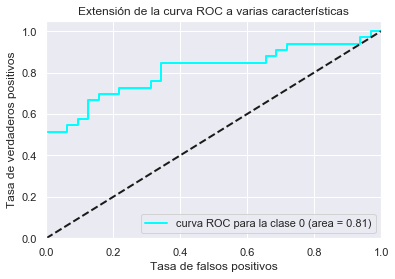

In [123]:
# Agregando las tasas de falsos positivos
all_fpr = np.unique(np.concatenate([fpr[0]]))

# Interpolar todas las curvas ROC 
mean_tpr = np.zeros_like(all_fpr)
for i in range(1):
    mean_tpr += interp(all_fpr, fpr[0], tpr[0])

# Promediando y calculando las AUC
mean_tpr /= 1

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficar todas las curvas
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(1), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='curva ROC para la clase {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Extensión de la curva ROC a varias características')
plt.legend(loc="lower right")
plt.show()

In [127]:
? roc_curve

¿Cuáles son sus aciertos, Falsos Positivos y Falsos Negativos?¿Es lo mismo si nos interesa la clase 0 que la clase 1? 

**Ejercicio:** Igual que antes. Calcular la precisión, exhaustividad (recall) y F-Score de este modelo para cada clase sobre el conjunto de Test. Pueden hacerlo a partir de la matriz de confusión o usando funciones que ya están incorporadas en Scikit-Learn.

### ¿Y si lo ponemos "en producción"?

In [124]:
X_no_medido = df_no_medido.drop('y', axis = 1).values
y_no_medido = df_no_medido.y.values

In [125]:
# Predecimos sobre todas las instancias que no vio
y_no_medido_pred = clf_2.predict(X_no_medido)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_no_medido_pred,y_no_medido))

Accuracy sobre conjunto de Train: 0.8080666666666667


In [126]:
confusion_matrix(y_no_medido, y_no_medido_pred)

array([[71822, 16870],
       [  404,   904]], dtype=int64)

¿Qué cambió?¿Es mejor o peor este modelo que el anterior árbol de decisión?

**Ejercicio:** medir precisión, exhaustividad y F-Score

**Ejercicio:** repetir para un modelo de vecinos más cercanos.

## 5. Dataset de Fraude

Los invitamos a trabajar con este dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud

Pueden encontrar un link a un lindo análisis en la presentación de la clase de hoy.